In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns;

from IPython import display
from common import *

tf.random.set_random_seed(123)

In [3]:
np.random.seed(123)
n_pos_sampels = 500
n_neg_samples = 500
x1, y_x1 = make_blobs(n_samples=n_pos_sampels, n_features=1, centers=[[0.4], [0.6]], cluster_std=[0.01, 0.005], random_state=123)

x0 = np.random.rand(n_neg_samples*10)
# mask = np.logical_or(np.logical_and(x0 > 0.25, x0 < 0.35), np.logical_and(x0 > 0.55, x0 < 0.65))
mask = np.logical_or(x0 < 0.3, x0 > 0.7)
x0 = x0[mask][:n_neg_samples]
y0 = np.zeros(n_pos_sampels, dtype=np.int64)
y1 = np.ones(n_neg_samples, dtype=np.int64)
x0 = x0[:, np.newaxis]
x = np.concatenate([x0, x1])
y = np.concatenate([y0, y1])

In [4]:
from common import attack_config
tf.reset_default_graph()
detector = Model(var_scope='detector', hidden_sizes=[500]*3, input_size=1)
detector_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='detector')
attack_config['num_steps'] = 20
attack_config['step_size'] = 0.05
attack_config['max_distance'] = 0.3

attack = PGDAttackDetector(detector, **attack_config, batch_size=x0.shape[0], input_size=1)

optimizer = tf.train.AdamOptimizer(5e-4)
train_step = optimizer.minimize(detector.xent)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


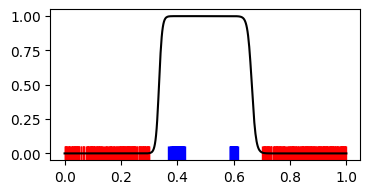

In [5]:
for i in range(500):
    sess.run(train_step,feed_dict={detector.x_input: x, detector.y_input: y})
fig, ax = plt.subplots(figsize=(4, 2), dpi=100)
ax.plot(x1, np.zeros(x1.shape[0]), '|', color='blue', markersize=10)
ax.plot(x0, np.zeros(x0.shape[0]), '|', color='red', markersize=10)

grid_x = np.linspace(0, 1, 500)[:, np.newaxis]
grid_y0 = sess.run(
    tf.sigmoid(detector.logits),
    feed_dict={detector.x_input:grid_x})
ax.plot(grid_x.squeeze(), grid_y0, 'k-')

In [6]:

ax.set_ylim([-0.1, 1])
ax.set_xlim([0, 1])
for i in range(2000):
    x0_adv = attack.perturb(x0, None, sess, verbose=False)
    x_with_adv = np.concatenate([x1, x0_adv])
    y_with_adv = np.concatenate([y1, y0])
    for k in range(1):
        sess.run(train_step,feed_dict={detector.x_input: x_with_adv, detector.y_input: y_with_adv})

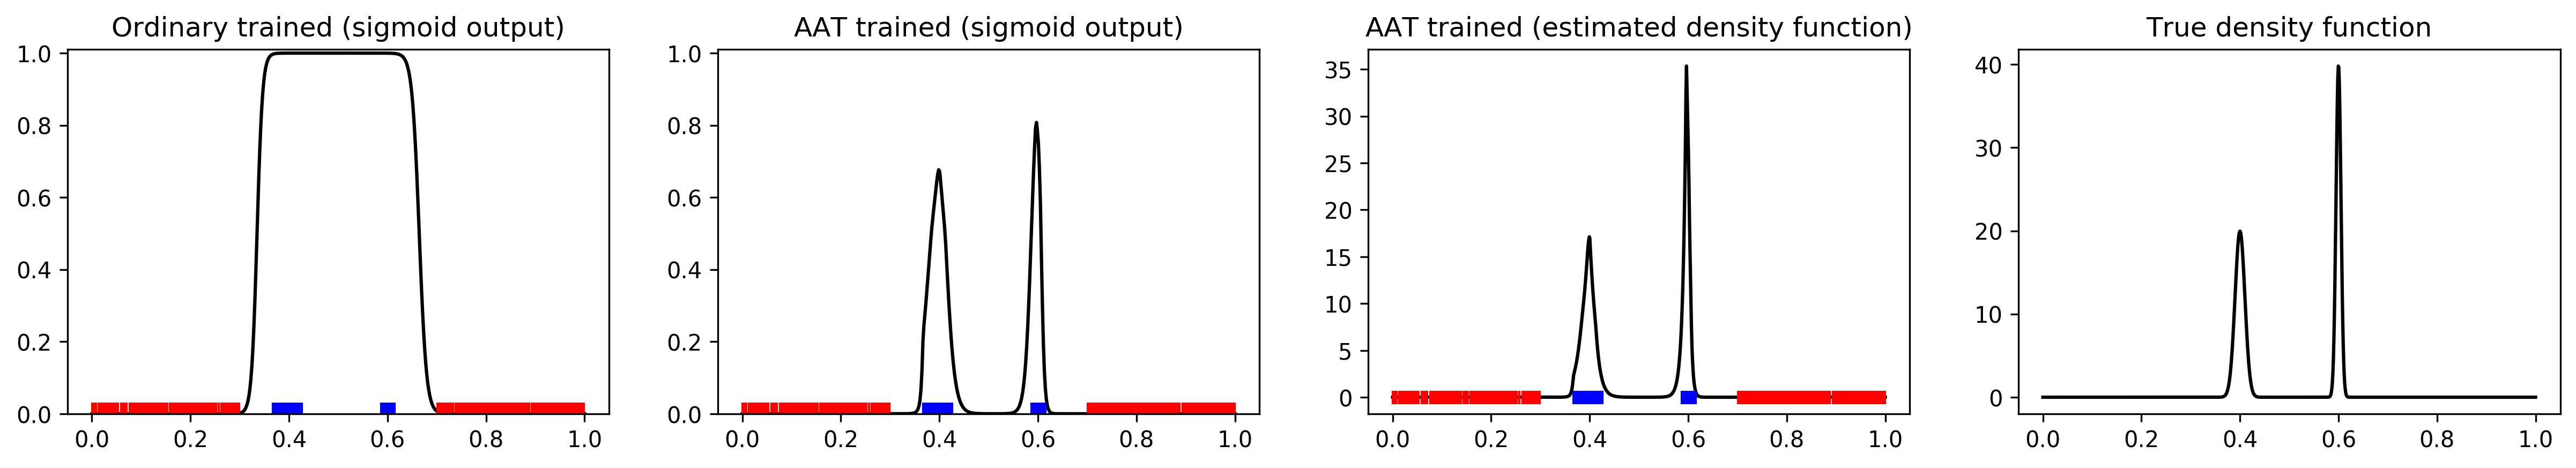

In [7]:

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20, 3), dpi=300)
ax0.set_ylim([0, 1.01])
ax0.set_title('Ordinary trained (sigmoid output)');

grid_x = np.linspace(0, 1, 500)[:, np.newaxis]
ax0.plot(grid_x.squeeze(), grid_y0, 'k-')
ax0.plot(x0, np.zeros(x0.shape[0]), '|', color='red', markersize=10)
ax0.plot(x1, np.zeros(x1.shape[0]), '|', color='blue', markersize=10)

ax1.set_ylim([0, 1.01])
x0_adv = attack.perturb(x0, None, sess, verbose=False)


grid_y = sess.run(
    tf.sigmoid(detector.logits),
    feed_dict={detector.x_input:grid_x})
ax1.plot(grid_x.squeeze(), grid_y, 'k-')

# sns.distplot(x1[y_x1==1].squeeze(), ax=ax1, norm_hist=True)


ax1.plot(x0, np.zeros(x0.shape[0]), '|', color='red', markersize=10)
ax1.plot(x1, np.zeros(x1.shape[0]), '|', color='blue', markersize=10)
ax1.set_title('AAT trained (sigmoid output)')

grid_x = np.linspace(0, 1, 1000)[:, np.newaxis]
grid_y = sess.run(
    tf.exp(detector.logits),
    feed_dict={detector.x_input:grid_x})
grid_y_normalized = grid_y/(grid_y.sum()*0.001)
ax2.plot(grid_x.squeeze(), grid_y_normalized, 'k-')

# ax2.set_ylim([0, 0.05])
ax2.plot(x0, np.zeros(x0.shape[0]), '|', color='red', markersize=6)
ax2.plot(x1, np.zeros(x1.shape[0]), '|', color='blue', markersize=6)
ax2.set_title('AAT trained (estimated density function)')

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

g_out = gaussian(grid_x, 0.4, 0.01) + gaussian(grid_x, 0.6, 0.005)
g_out_normalized = g_out/(g_out.sum()*0.001)
ax3.plot(grid_x, g_out_normalized, 'k-')
ax3.set_title('True density function')


plt.savefig('1d.pdf', bbox_inches = 'tight', pad_inches=0)